In [1]:
# import warnings
# warnings.simplefilter("ignore")

# autoreload import your package
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

In [3]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [4]:
from pts.model.tempflow import TempFlowEstimator
from pts.model.time_grad2 import TimeGradEstimator2
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

In [6]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers']


In [7]:
# exchange_rate_nips, electricity_nips, traffic_nips, solar_nips, wiki-rolling_nips, ## taxi_30min is buggy still
dataset = get_dataset("electricity_nips", regenerate=False)

In [8]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='370')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [9]:
train_grouper = MultivariateGrouper(max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

test_grouper = MultivariateGrouper(
    num_test_dates=int(len(dataset.test)/len(dataset.train)*2),
#     num_test_dates=7,
                                   max_target_dim=min(2000, int(dataset.metadata.feat_static_cat[0].cardinality)))

In [10]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

/home/wassname/miniforge3/envs/glounts/lib/python3.9/site-packages/gluonts/dataset/multivariate_grouper.py:191: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return {FieldName.TARGET: np.array([funcs(data) for data in dataset])}


## Train

In [11]:
estimator = TimeGradEstimator2(
    target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    cell_type='GRU',
    input_size=1484,
    freq=dataset.metadata.freq,
    loss_type='l2',
    scaling=True,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule="linear",
    trainer=Trainer(device=device,
                    epochs=20,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64,)
)

In [12]:
# predictor = estimator.train(dataset_train, num_workers=0)
predictor = estimator.train(dataset_train, num_workers=8)

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

In [13]:
# %debug

## Forecast

In [27]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=100)

forecasts = list(forecast_it)
targets = list(ts_it)

In [28]:
# %debug

In [29]:
# x_hat * self.scale.permute(0, 2, 1)[:1]

## Plot

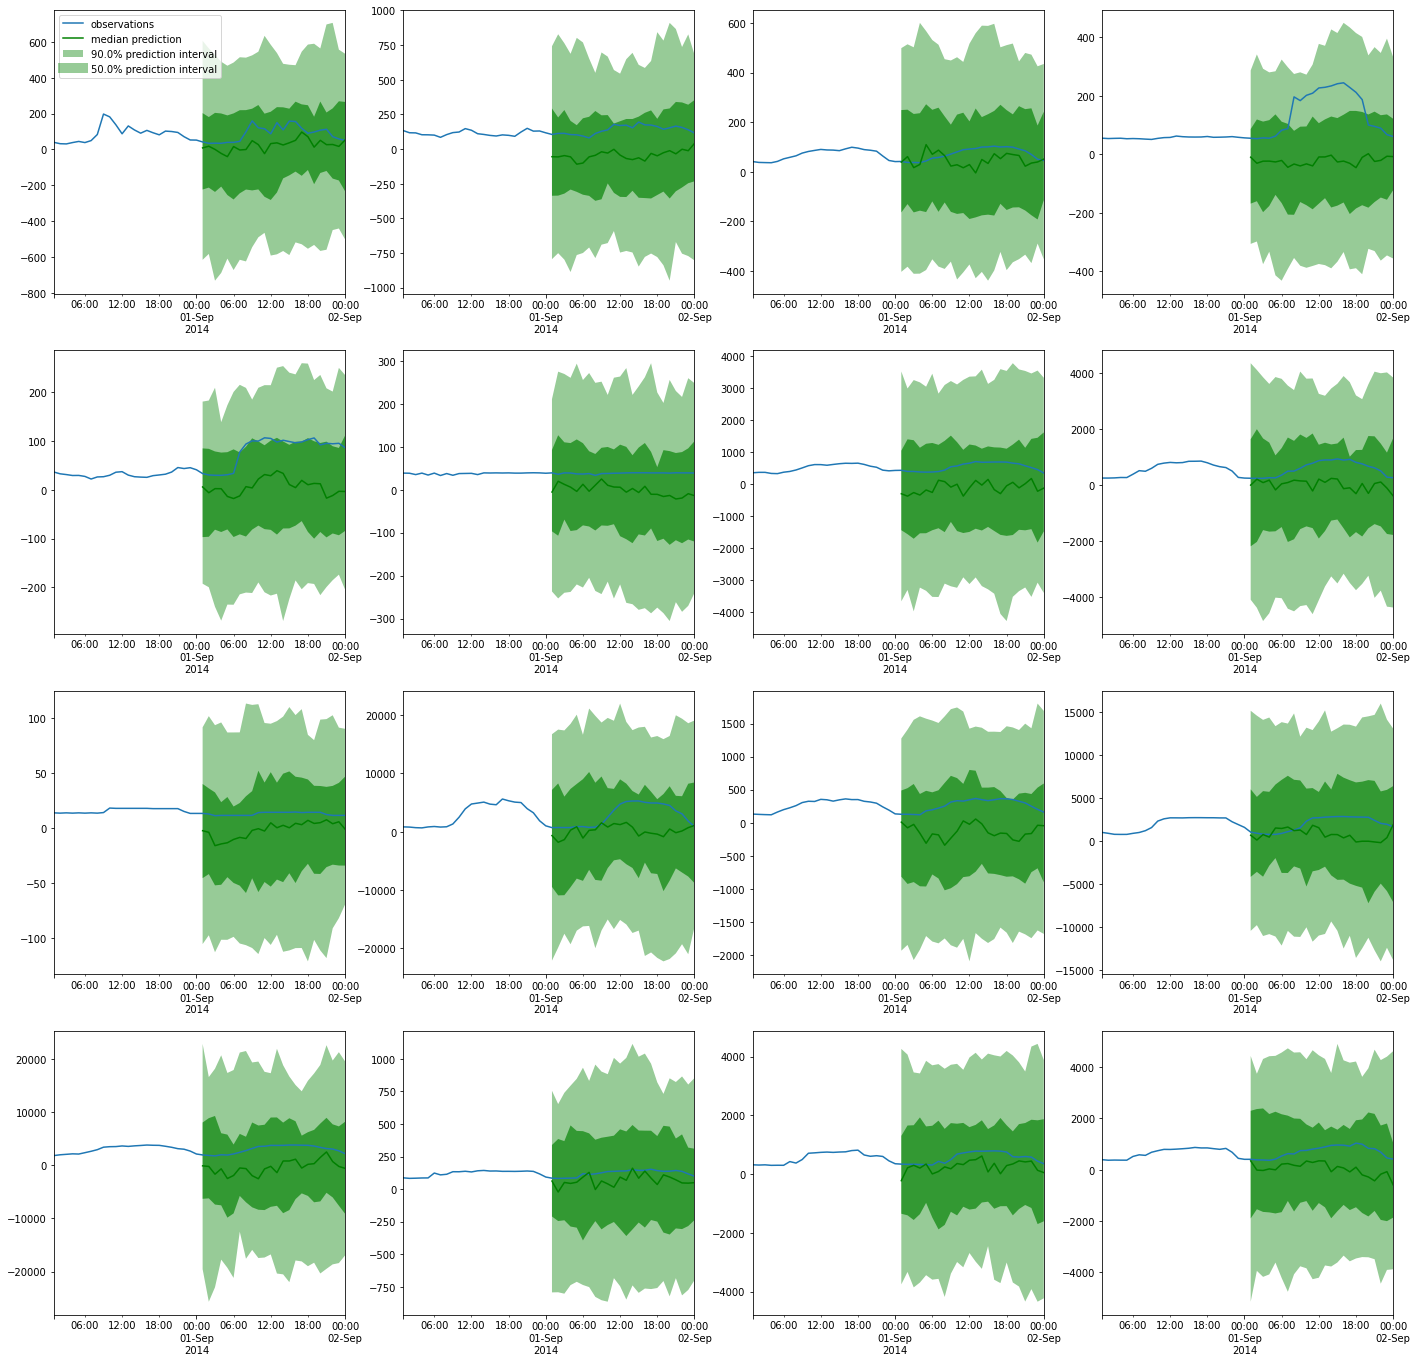

In [30]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)
        
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()

In [31]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [32]:
agg_metric, item_metrics = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 151.21it/s]
Running evaluation: 7it [00:00, 156.67it/s]
Running evaluation: 7it [00:00, 192.62it/s]
Running evaluation: 7it [00:00, 192.32it/s]
Running evaluation: 7it [00:00, 188.02it/s]
Running evaluation: 7it [00:00, 193.28it/s]
Running evaluation: 7it [00:00, 195.61it/s]
Running evaluation: 7it [00:00, 195.35it/s]
Running evaluation: 7it [00:00, 193.99it/s]
Running evaluation: 7it [00:00, 193.99it/s]
Running evaluation: 7it [00:00, 194.13it/s]
Running evaluation: 7it [00:00, 185.22it/s]
Running evaluation: 7it [00:00, 192.47it/s]
Running evaluation: 7it [00:00, 194.77it/s]
Running evaluation: 7it [00:00, 194.23it/s]
Running evaluation: 7it [00:00, 193.09it/s]
Running evaluation: 7it [00:00, 192.30it/s]
Running evaluation: 7it [00:00, 194.60it/s]
Running evaluation: 7it [00:00, 194.02it/s]
Running evaluation: 7it [00:00, 194.20it/s]
Running evaluation: 7it [00:00, 166.73it/s]
Running evaluation: 7it [00:00, 190.92it/s]
Running evaluation: 7it [00:00, 

Running evaluation: 7it [00:00, 193.33it/s]
Running evaluation: 7it [00:00, 192.55it/s]
Running evaluation: 7it [00:00, 190.83it/s]
Running evaluation: 7it [00:00, 192.37it/s]
Running evaluation: 7it [00:00, 192.45it/s]
Running evaluation: 7it [00:00, 193.15it/s]
Running evaluation: 7it [00:00, 158.96it/s]
Running evaluation: 7it [00:00, 193.38it/s]
Running evaluation: 7it [00:00, 192.98it/s]
Running evaluation: 7it [00:00, 192.97it/s]
Running evaluation: 7it [00:00, 192.20it/s]
Running evaluation: 7it [00:00, 157.28it/s]
Running evaluation: 7it [00:00, 159.54it/s]
Running evaluation: 7it [00:00, 195.29it/s]
Running evaluation: 7it [00:00, 34.25it/s]
Running evaluation: 7it [00:00, 194.70it/s]
Running evaluation: 7it [00:00, 193.68it/s]
Running evaluation: 7it [00:00, 195.91it/s]
Running evaluation: 7it [00:00, 193.03it/s]
Running evaluation: 7it [00:00, 190.39it/s]
Running evaluation: 7it [00:00, 193.65it/s]
Running evaluation: 7it [00:00, 192.67it/s]
Running evaluation: 7it [00:00, 1

Running evaluation: 7it [00:00, 190.42it/s]
Running evaluation: 7it [00:00, 189.33it/s]
Running evaluation: 7it [00:00, 194.73it/s]
Running evaluation: 7it [00:00, 194.68it/s]
Running evaluation: 7it [00:00, 194.87it/s]
Running evaluation: 7it [00:00, 193.06it/s]
Running evaluation: 7it [00:00, 193.41it/s]
Running evaluation: 7it [00:00, 192.88it/s]
Running evaluation: 7it [00:00, 193.53it/s]
Running evaluation: 7it [00:00, 193.23it/s]
Running evaluation: 7it [00:00, 190.94it/s]
Running evaluation: 7it [00:00, 189.98it/s]
Running evaluation: 7it [00:00, 191.22it/s]
Running evaluation: 7it [00:00, 192.33it/s]
Running evaluation: 7it [00:00, 191.35it/s]
Running evaluation: 7it [00:00, 192.65it/s]
Running evaluation: 7it [00:00, 158.27it/s]
Running evaluation: 7it [00:00, 157.50it/s]
Running evaluation: 7it [00:00, 140.75it/s]


In [33]:
print("CRPS:", agg_metric["mean_wQuantileLoss"])
print("ND:", agg_metric["ND"])
print("NRMSE:", agg_metric["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric["m_sum_ND"])
print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])

CRPS: 1.1069321160944334
ND: 1.003746678968134
NRMSE: 7.097175779249079

CRPS-Sum: 0.6612398866066339
ND-Sum: 0.98568530431658
NRMSE-Sum: 1.075262764787951
